# 1. **Introduction**
In this model we use BERT to attain word embeddings for sentences and then determine clusters within our documents and extract the closest sentence in each cluster to form a summary of the overall document.

This method is a variant of extractive summarization where we extract the most meaningful sentences from the document instead of actually writing summaries in an abstractive manner. 

Before we delve into the method we talk a little bit about BERT 

BERT is a transformer based model developed by Google [see reference here](https://arxiv.org/abs/1810.04805). The model achieved success in many bench-mark tests, such as translation, Q&A, and sentence classification, around 2018-2019, and is considered by many to be the-state-of-the-art performance in the field. 

The innovation behind BERT's success are a combination of a few key things.

### 1. **Bi-directional Encoding**

During the training of BERT the model reads in the entire sequences of tokens at once instead of doing it step by step from left to right as is tradiitonal in RNN based model. This solves the information bottleneck as information on the left side (i.e. beginning of phrase/sentence/paragraph) and on the right side provide context for each others (see below.) This is in contradistinction to directional encoder, where information on the end side of the text is not accessible to the front of the text.

![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/09/bert-vs-openai-.jpg)


### 2. **Masked Language Model**

During the training, 15% of the words are masked out. The model is trained to predict the masked out words using the surrounding context (i.e. the unmasked words). See below where the word W4 is masked out, and the model is trained to retrieved the masked out word back. This kind of training is called self-supervised learning, meaning the labels are extracted directly from the dataset. In this way, the model "learns" the semantic of words by contextual information.

![alt text](https://miro.medium.com/max/1205/0*ViwaI3Vvbnd-CJSQ.png)


### 3. **Next Sentence Prediction**

The training of BERT model also incorporate sentence level information. The model gets a pair of sentences as input and learn to predict if the second sentence is the pair of the other sentence in the original document.

This task is done using a special token denoting the start and end of sentence. There are 3 kinds of embedding tokens used for training.

- special token embedding: [CLS] and [SEP] for start and end of sentence
-  paired sentence embedding: denoting sentence A and sentence B
- Positional embedding: denoting position in sequences.

![alt text](https://miro.medium.com/max/1614/0*m_kXt3uqZH9e7H4w.png)

We will be using the [CLS] trick in our extractive summarization later.

In the end we get an encoder model where the weights capture the contextual information of language both in word level and sentence level. The idea is then to use this language model as a base model and build specific tasks on top of this.

# 2. Packages

We will be using Huggingface transformers library. The version we use is pytorch-based. This is a pretty nice and well-documented NLP models, including BERT, GPT-2, Pegasus and a lot more. For this pre-trained work, we won't be doing fine-tuning. So GPU is probably not necessary.

## 2.1 packages

In [ ]:
!pip install transformers # insall the huggingface library

In [2]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from keras.preprocessing.sequence import pad_sequences

from scipy.spatial.distance import pdist,squareform
from sklearn.decomposition import PCA

import torch
import transformers as ppb 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2.2 Load Model

We will be using distilbert (which is a smaller version of BERT). It is 40% smaller in size, has 97% capability of base BERT, abd 60% faster.
The version we use is 'uncased' meaning the tokens are all lower-cases. 

In [98]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
#config = BertConfig.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights, output_hidden_states = True)

# 3. Data preprocessing

The task consists of

1. split paragraphs into sentence (if hasn't been done already).

2. tokenize the words in sentences to a list of numeric; add the special tokens for start and end.

3. truncating or padding.

4. Create attention masks that tell the BERT model which parts are padding and which are words.

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
data = pd.read_csv("/gdrive/MyDrive/Summarizer/structured_df.csv")
data.head()

,Unnamed: 0,course_title,section_topic,subsection_topic,lecture_topic,content
0,0,advanced-methods-reinforcement-learning-finance,other-applications-of-reinforcement-learning-p...,lesson-1,trades-quotes-and-order-flow,All right. Let's first talk about what type of...
1,1,advanced-methods-reinforcement-learning-finance,other-applications-of-reinforcement-learning-p...,lesson-1,electronic-markets-and-lob,"So, so far in this specialization our examples..."
2,2,advanced-methods-reinforcement-learning-finance,other-applications-of-reinforcement-learning-p...,lesson-1,welcome,Welcome to week four of our course on events t...
3,3,advanced-methods-reinforcement-learning-finance,other-applications-of-reinforcement-learning-p...,lesson-1,limit-order-book,"Now, let's talk a bit more about the Limit Ord..."
4,4,advanced-methods-reinforcement-learning-finance,other-applications-of-reinforcement-learning-p...,lesson-1,lob-modeling,"Now, after we talked about what the LOB is, le..."


## 3.1 Paragraph spliting

We take the first entry from the dataset created and explore the topics in this 

In [169]:
# Taking a Sample Text from our dataset
paragraph = data.loc[80,"content"]
paragraph

'What makes a company good at AI? Perhaps even more importantly, what will it take for your company to become great at using AI? I had previously led the Google brain team, and Baidu\'s AI group, which I respectively helped Google and Baidu become great AI companies. So, what can you do for your company? This is the lesson I had learned to washing the rise of the Internet that I think will be relevant to how all of us navigate the rise of AI. Let\'s take a look. A lesson we learned from the rise of the Internet was that, if you take your favorite shopping mall. So, my wife and I sometimes shop at Stanford shopping center and you build a website for the Shopping mall. Maybe sell things on the website, that by itself does not turn the shopping mall into an internet company. In fact, a few years ago I was speaking with the CEO of a large retail company who said to me, "Hey Andrew, I have a website, I sell things in the website." Amazon has a website, Amazon sells things on website is the 

In [170]:
paragraph_split = sent_tokenize(paragraph) # split the paragraph

In [171]:
paragraph_split
len(paragraph_split)

64

## 3.2 Tokenization

Note the start token [CLS] is always denoted numerically as [101] and the end token [SEP] is always [102].

In [172]:
input_tokens = []
for i in paragraph_split:
  encoding = tokenizer.encode(i, add_special_tokens=True)
  input_tokens.append(encoding)
  #print(encoding)

In [173]:
temp = []
for i in input_tokens:
  #print(len(i))
  temp.append(len(i))
np.max(temp)  # the longest sentence in our paragraph has 42 tokens. 

53

In [174]:
# Method to convert our encodings back into sequences
for i in input_tokens[:5]:
  print(i)
  print(tokenizer.convert_ids_to_tokens(i))

[101, 2054, 3084, 1037, 2194, 2204, 2012, 9932, 1029, 102]
['[CLS]', 'what', 'makes', 'a', 'company', 'good', 'at', 'ai', '?', '[SEP]']
[101, 3383, 2130, 2062, 14780, 1010, 2054, 2097, 2009, 2202, 2005, 2115, 2194, 2000, 2468, 2307, 2012, 2478, 9932, 1029, 102]
['[CLS]', 'perhaps', 'even', 'more', 'importantly', ',', 'what', 'will', 'it', 'take', 'for', 'your', 'company', 'to', 'become', 'great', 'at', 'using', 'ai', '?', '[SEP]']
[101, 1045, 2018, 3130, 2419, 1996, 8224, 4167, 2136, 1010, 1998, 21790, 8566, 1005, 1055, 9932, 2177, 1010, 2029, 1045, 4414, 3271, 8224, 1998, 21790, 8566, 2468, 2307, 9932, 3316, 1012, 102]
['[CLS]', 'i', 'had', 'previously', 'led', 'the', 'google', 'brain', 'team', ',', 'and', 'bai', '##du', "'", 's', 'ai', 'group', ',', 'which', 'i', 'respectively', 'helped', 'google', 'and', 'bai', '##du', 'become', 'great', 'ai', 'companies', '.', '[SEP]']
[101, 2061, 1010, 2054, 2064, 2017, 2079, 2005, 2115, 2194, 1029, 102]
['[CLS]', 'so', ',', 'what', 'can', 'you', 

Recap, so far we are about this step.

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

## 3.3 Truncating and padding

The BERT model has input dimension of 512 in size. So if our sentence has more than 512 tokens, we have to truncate it somehow. In our case the max token length = 42, so this won't be necessary. 

Also, because the sentences have different lengths, we will pad the shorter ones with [PAD] which is numerically [0].

In [176]:
# Padding our tokens to a length of 50 cause the max length of any sentence in the example is 53. 
input_ids = pad_sequences(input_tokens, maxlen=50, dtype="long", value=0, truncating="post", padding="post")

In [177]:
# Here we can see that we have a 50 dim vector for each one of the 60 sentences
input_ids.shape

(64, 50)

## 3.4 Attention Mask

This is a embedding layer of values [0] or [1]. The purpose is to tell the model to ignore the padding.

In [178]:
def create_attention_mask(input_id):
  attention_masks = []
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]  # create a list of 0 and 1.
    attention_masks.append(att_mask)  # basically attention_masks is a list of list
  return attention_masks

In [179]:
input_masks = create_attention_mask(input_ids)

After this is done, then we can turn our data to torch tensor object.

In [180]:
input_ids = torch.tensor(input_ids)  
attention_mask = torch.tensor(input_masks)

# 4. Embedding

Notice that 768 is the hidden layer dimensions of the model. The model has 6 transformer layer blocks (the base-bert has 12 layers). The output has dimensions of 768 in size.

In [181]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<40} {:>12}".format(p[0], str(tuple(p[1].size())))) 
    # As we want the code to be visuall appealing we right align the first format box and specify a field size of 40
    # We then left align the second format box and specify a field size of 12

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 100 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight        (30522, 768)
embeddings.position_embeddings.weight      (512, 768)
embeddings.LayerNorm.weight                    (768,)
embeddings.LayerNorm.bias                      (768,)
transformer.layer.0.attention.q_lin.weight   (768, 768)

==== First Transformer ====

transformer.layer.0.attention.q_lin.bias                      (768,)
transformer.layer.0.attention.k_lin.weight                (768, 768)
transformer.layer.0.attention.k_lin.bias                      (768,)
transformer.layer.0.attention.v_lin.weight                (768, 768)
transformer.layer.0.attention.v_lin.bias                      (768,)
transformer.layer.0.attention.out_lin.weight              (768, 768)
transformer.layer.0.attention.out_lin.bias                    (768,)
transformer.layer.0.sa_layer_norm.weight                      (768,)
transformer.layer.0.sa_layer_norm.bias                        (768,

In [182]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Recall earlier that we has something to say about the [CLS] tokens used for start sentence embedding. So after you pass through the BERT model, this becomes the tensor position [0] and has hidden dimensions of 768. 

The BERT uses this token to sepresent sentence information. In other words, the semantic information of the whole sentence should be embedded in this 768 feature dimension. In fact, the BERT sentence classification only use this dimension of the tensor for subsequent classification task.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

In [183]:
h = last_hidden_states.hidden_states
len(h)

7

In [184]:
# As per the reading of research papers we use the second last hidden state to get the sentence embeddings 
sentence_features = h[5][:,0,:].detach().numpy()

In [185]:
sentence_features.shape  
# get the embedding sentence data shape = (number of sentence, BERT hidden layer)

(64, 768)

In [186]:
len(sentence_features)

64

# 5. Machine Learning

We then can use the traditional machine learning tool, such as nearest-beighbors or clustering, to select relevant sentences.

## 5.1 Visualization

In [187]:
array_similarity = squareform(pdist(sentence_features, metric='euclidean'))

We use euclidean distance to measure how close in semantic space are the sentences in our paragraph. 


Text(0.5, 1.0, 'visualizing sentence semantic similarity')

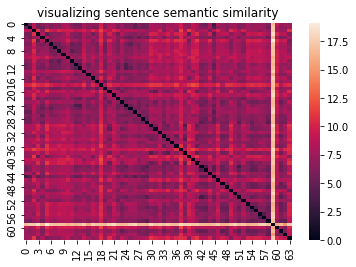

In [188]:
sns.heatmap(array_similarity)
plt.rcParams["figure.figsize"] = (15,12)
plt.title('visualizing sentence semantic similarity')

In [189]:
pca = PCA(n_components=2)
pca.fit(sentence_features)
print(np.sum(pca.explained_variance_ratio_))

0.33320138


In [190]:
pca_sentence_features = pca.transform(sentence_features)
pca_sentence_features

array([[ 1.4307677 , -0.39676464],
       [ 1.5258977 , -0.7377564 ],
       [-3.59563   , -0.04727522],
       [ 4.6637983 , -0.90232193],
       [-0.14720519,  0.10436001],
       [ 5.334371  , -1.4710528 ],
       [ 3.2451    ,  0.01927009],
       [ 2.6427617 ,  0.7389737 ],
       [ 3.6082928 ,  0.64163935],
       [ 2.6788397 ,  0.90837383],
       [ 0.3124285 ,  1.2937365 ],
       [ 3.2652695 ,  0.8247744 ],
       [ 1.383114  ,  0.45197934],
       [ 2.4435174 ,  0.24157657],
       [-0.2997435 , -1.3886712 ],
       [ 0.9052795 ,  1.3818588 ],
       [ 3.3655314 , -0.47146538],
       [ 1.6992301 ,  0.12860593],
       [ 1.202791  ,  1.981553  ],
       [ 1.7205987 ,  0.4431435 ],
       [-2.9871607 , -1.7382455 ],
       [ 2.2938273 , -1.062494  ],
       [ 2.439206  , -0.09562775],
       [-1.7063932 , -0.39917928],
       [ 0.7139072 , -0.2802665 ],
       [ 2.188298  , -0.69327027],
       [ 1.4009337 , -1.5098758 ],
       [-0.05555371, -0.10574561],
       [ 0.29855502,

Text(0.5, 1.0, '2D PCA projection of embedded sentences from BERT')

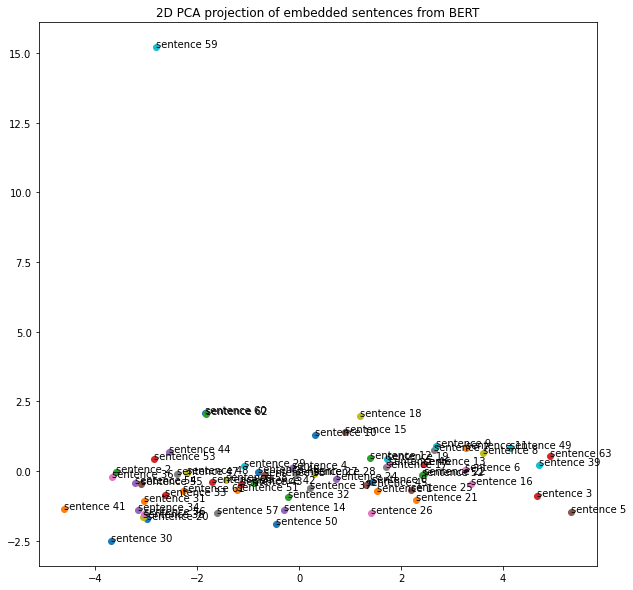

In [191]:
plt.figure(figsize=(10,10))
for i in range(len(pca_sentence_features)):
  plt.scatter(pca_sentence_features[i,0],pca_sentence_features[i,1])
  plt.annotate('sentence '+ str(i),(pca_sentence_features[i,0],pca_sentence_features[i,1]))
plt.title('2D PCA projection of embedded sentences from BERT')

## 5.2 extracting relevant sentences

We now have many avenues to choose how to pick particular the sentences.

In [192]:
# Now from our PCA we have the data required to run a K means Clustering. We will do that to find 4 clusters and extract the closest sentences to the centroid
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# assume the total number of data is 100
all_data = [ i for i in range(len(sentence_features)) ]
tf_matrix = sentence_features
print("Got the Data")
#print(tf_matrix)

# set your own number of clusters
num_clusters = 2

m_km = KMeans(n_clusters=num_clusters)  
m_km.fit(tf_matrix)
m_clusters = m_km.labels_.tolist()
print("Got Cluster labels for each point ")
#print(m_clusters)

centers = np.array(m_km.cluster_centers_)

closest_data = []
for i in range(num_clusters):
    center_vec = centers[i]
    #print("Centroid Vector is ",center_vec)
    data_idx_within_i_cluster = [ idx for idx, clu_num in enumerate(m_clusters) if clu_num == i ]
    print("Data in cluster {} is {}".format(i, data_idx_within_i_cluster))

    one_cluster_tf_matrix = np.zeros( (  len(data_idx_within_i_cluster) , centers.shape[1] ) )
    for row_num, data_idx in enumerate(data_idx_within_i_cluster):
        one_row = tf_matrix[data_idx]
        one_cluster_tf_matrix[row_num] = one_row
    
    print(one_cluster_tf_matrix.shape)

    closest, _ = pairwise_distances_argmin_min(center_vec.reshape(1,-1), one_cluster_tf_matrix)
    closest_idx_in_one_cluster_tf_matrix = closest[0]
    closest_data_row_num = data_idx_within_i_cluster[closest_idx_in_one_cluster_tf_matrix]
    data_id = all_data[closest_data_row_num]

    closest_data.append(data_id)

closest_data = list(set(closest_data))

assert len(closest_data) == num_clusters

Got the Data
Got Cluster labels for each point 
Data in cluster 0 is [2, 4, 14, 20, 23, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41, 42, 43, 44, 47, 48, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
(35, 768)
Data in cluster 1 is [0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26, 37, 39, 45, 46, 49, 52, 63]
(29, 768)


In [205]:
#closest_data

#final_text = [".".join(input_tokens[i]) for i in closest_data]
#input_tokens[16]
final_text = []
for i in closest_data:
  input = input_tokens[i]
  sequence = tokenizer.convert_ids_to_tokens(input)
  print(sequence)
  string = tokenizer.convert_tokens_to_string(sequence)
  print(string)
  final_text.append(string)

final_text = "".join(final_text)
final_summary = final_text.replace("[CLS]","").replace("[SEP]",".").strip()
print("\nFinal Summary:\n{}".format(final_summary))

['[CLS]', 'so', ',', 'how', 'can', 'a', 'company', 'become', 'good', 'at', 'ai', '?', '[SEP]']
[CLS] so , how can a company become good at ai ? [SEP]
['[CLS]', 'now', ',', 'one', 'of', 'the', 'challenges', 'of', 'doing', 'ai', 'projects', 'such', 'as', 'the', 'pilot', 'projects', 'in', 'step', 'one', 'is', 'understanding', 'what', 'ai', 'can', 'and', 'cannot', 'do', '.', '[SEP]']
[CLS] now , one of the challenges of doing ai projects such as the pilot projects in step one is understanding what ai can and cannot do . [SEP]

Final Summary:
so , how can a company become good at ai ? . now , one of the challenges of doing ai projects such as the pilot projects in step one is understanding what ai can and cannot do . .


# Citation
Part of the codes and illustrations are adapted from this very easy-to-understand notebook.

- [visual notebook for first time users](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)


Additionaly Resources Used:

- [The original BERT paper](https://arxiv.org/pdf/1810.04805.pdf)

- [The DiltilBERT paper](https://arxiv.org/pdf/1910.01108.pdf)

- [Huggingface library](https://github.com/huggingface/transformers)